<h1 style="text-align:center;background-color:#0e4b90;color:white">UNET za segmentaciju tela</h1><br>

# Učitavanje biblioteka

In [ ]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Model
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input

In [4]:
# putanje do foldera gde se nalaze nase slike
imgs_dir = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/images'
masks_dir = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/masks'
backgrounds = '/kaggle/input/segmentation-backgrounds/back_za_projekat'

# Učitavanje podataka

In [5]:
imgs_arr = np.zeros((len(os.listdir(imgs_dir)), 256, 256, 3), dtype = np.float32)
backs_arr = np.zeros((len(os.listdir(backgrounds)), 256, 256, 3), dtype = np.float32)
masks_arr = np.zeros((len(os.listdir(masks_dir)), 256, 256, 1), dtype = np.float32)



for index in range(len(os.listdir(imgs_dir))):
    img = load_img(os.path.join(imgs_dir, os.listdir(imgs_dir)[index]), target_size = (256, 256, 3))
    imgs_arr[index] = img_to_array(img)
    
for index in range(len(os.listdir(backgrounds))):
    img = load_img(os.path.join(backgrounds, os.listdir(backgrounds)[index]), target_size = (256, 256, 3))
    backs_arr[index] = img_to_array(img)
    


for index in range(len(os.listdir(masks_dir))):
    img = load_img(os.path.join(masks_dir, os.listdir(masks_dir)[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    masks_arr[index] = img_to_array(img)


imgs_arr /= 255.
backs_arr /= 255.
masks_arr /= 255.

x_train = imgs_arr[10:]
y_train = masks_arr[10:]

x_test = imgs_arr[0:10]
y_test = masks_arr[0:10]

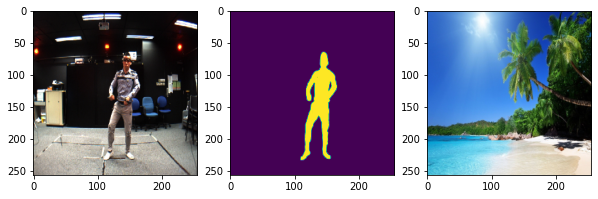

In [10]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,10))
f.add_subplot(1,3, 1)
plt.imshow(imgs_arr[0])
f.add_subplot(1,3, 2)
plt.imshow(masks_arr[0])
f.add_subplot(1,3,3)
plt.imshow(backs_arr[0])
plt.show(block=True)

<h1 style="text-align:center;background-color:#0e4b90;color:white">UNET model</h1><br>

<p style="text-align:center">Pre nego što budemo pričali o UNET-u, hajde da razumemo šta je zadatak ovog modela.<br>
Za razliku od klasične klasifikacije gde predviđamo klasu za celu sliku, u semantičkoj segmentaciji želimo da predvidimo klasu za svaki pojedinačni piksel <br>
(u ovom slučaju da li je to ljudsko telo ili samo pozadina, što je binarna klasifikacija). Ova tehnika se takođe koristi za zadatak autonomne vožnje gde naš algoritam <br>
klasifikuje da li pikseli pripadaju automobilima, ljudima, semaforima, saobraćajnim znakovima, itd. <br>
Dakle, kako da napravimo ovaj model? Jedan od modela koji se pokazao kao dobar za ovaj zadatak je UNET</p>
<div style="text-align:center"><img src="https://miro.medium.com/max/680/1*TXfEPqTbFBPCbXYh2bstlA.png"/ style="width:600px;height:400px;"></div><br><br>
<p style="text-align:center">Unet ima dva dela u svojoj arhitekturi. Prvi deo je sažimajući deo (koder), a drugi deo je prosiravajuci deo(dekoder)<br>
U koderu imamo standardnu arhitekturu poput cnn-a sa dva Conv2D sloja praćena MaxPool-om (osim u sloju uskog grla (5. cnn sloj))<br>
U dekoderu imamo transponovanu konvoluciju sa korakom(stride) od 2 i 'same' dopunom koji će udvostručiti dimenzije naše ulazne slike.<br>
Nakon te transponovane konvolucije, spojićemo njen izlaz sa izlazom odgovarajućeg konvolucionog sloja u koderu.<br>
Ovu konkatenaciju smo uradili tako da naš dekoder znao o reprezentacijama karakteristika koje proizvode naši konvolucioni slojevi, što će nam pomoći da lakše klasifikujemo piksle slike.<br><br>
(Ova implementacija nije ista kao u originalnom papiru. Dodao sam grupnu normalizaciju(batch normalization) i leakyReLU i koristio sam same padding umesto valid paddinga).</p>

In [11]:
def conv_block(inputs,filters,max_pool=True):
    conv1 = Conv2D(filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(inputs)
    bn1 = BatchNormalization()(conv1)
    ac1 = LeakyReLU(0.2)(bn1)
    conv2 = Conv2D(filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(ac1)
    bn2 = BatchNormalization()(conv2)
    ac2 = LeakyReLU(0.2)(bn2)
    skip = ac2
    if max_pool:
        mp = MaxPool2D()(ac2)
        next_layer_input = mp
    else:
        next_layer_input = ac2
    
    return next_layer_input, skip

def up_block(inputs,skip_inputs,filters):
    trans_conv1 = Conv2DTranspose(filters,3,2,padding='same')(inputs)
    x = concatenate([trans_conv1,skip_inputs],axis=3)
    b = conv_block(x,filters,max_pool=False)
    return b[0]

In [12]:
def unet_from_scratch(input_size=(256,256,3),number_of_classes=1):
    inputs = Input(shape=input_size)
    conv1 = conv_block(inputs,32)
    conv2 = conv_block(conv1[0],64)
    conv3 = conv_block(conv2[0],128)
    conv4 = conv_block(conv3[0],256)
    conv5 = conv_block(conv4[0],512,max_pool=False)
    up1 = up_block(conv5[0],conv4[1],256)
    up2 = up_block(up1,conv3[1],128)
    up3 = up_block(up2,conv2[1],64)
    up4 = up_block(up3,conv1[1],32)
    
    conv6 = Conv2D(32,3,padding='same',kernel_initializer='he_normal',use_bias=False)(up4)
    bn = BatchNormalization()(conv6)
    leaky = LeakyReLU(0.2)(bn)
    outputs = Conv2D(number_of_classes,1,padding='same',activation='sigmoid')(leaky)
    unet = Model(inputs=inputs,outputs=outputs)
    return unet

<h1 style="text-align:center;background-color:#0e4b90;color:white">Funkcija gubitka</h1><br>
<p style="text-align:center">U segmentaciji, korišćenje tačnosti(accuracy) za metriku evaluacije modela nije dobra ideja. Zašto?<br>
Pa, uzmimo hipotetički slučaj gde pokušavamo da segmentišemo jako male objekte na slici i recimo da oni zauzimaju oko 3% piksela u celoj slici.<br>
Ako predvidimo da slika nema nijedan od ovih malih objekata (maska puna 0), tačnost našeg modela će biti 97% što nije dobar prikaz stvarnih performansi našeg modela.<br>Ali postoji još jedna metrika koja nam pomaže u rešavanju ovog problema, a zove se IoU (Intersection over Union).</p><br><br>
<div style="text-align:center"><img src="https://miro.medium.com/max/1838/0*nm8gO9HZoLU7IES2" style="width:600px;height:400px;"></div><br><br>
<p style="text-align:center">IoU, takođe poznat kao Jaccardov koeficijent sličnosti, je statistika koja se koristi za merenje sličnosti i raznolikosti skupova uzoraka.<br>
Što je presek veći, to je precizniji izlaz. Na presek možemo gledati kao na istinski pozitivan rezultat (predvidjeli smo klasu piksela koja zaista jeste),<br>
a delovi koji se ne preklapaju kao lažno negativne i lažno pozitivne<br>
Iz ovoga možemo da izgradimo bolju metriku za procenu našeg modela, a takođe i kreiramo funkciju gubitka koju će naš model pokušati da minimizuje (tj da maksimizuje IoU).<br> Ovaj gubitak je poznat kao Jaccard-ov gubitak.</p>

In [13]:
# definicija funkcije gubitka
from keras import backend as K
def jaccard_coef(y_true,y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)-intersection+smooth)
def jaccard_loss(y_true,y_pred,smooth=1):
    return -jaccard_coef(y_true,y_pred,smooth)

2021-12-12 14:18:38.816368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 14:18:38.941222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 14:18:38.942367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 14:18:38.944273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

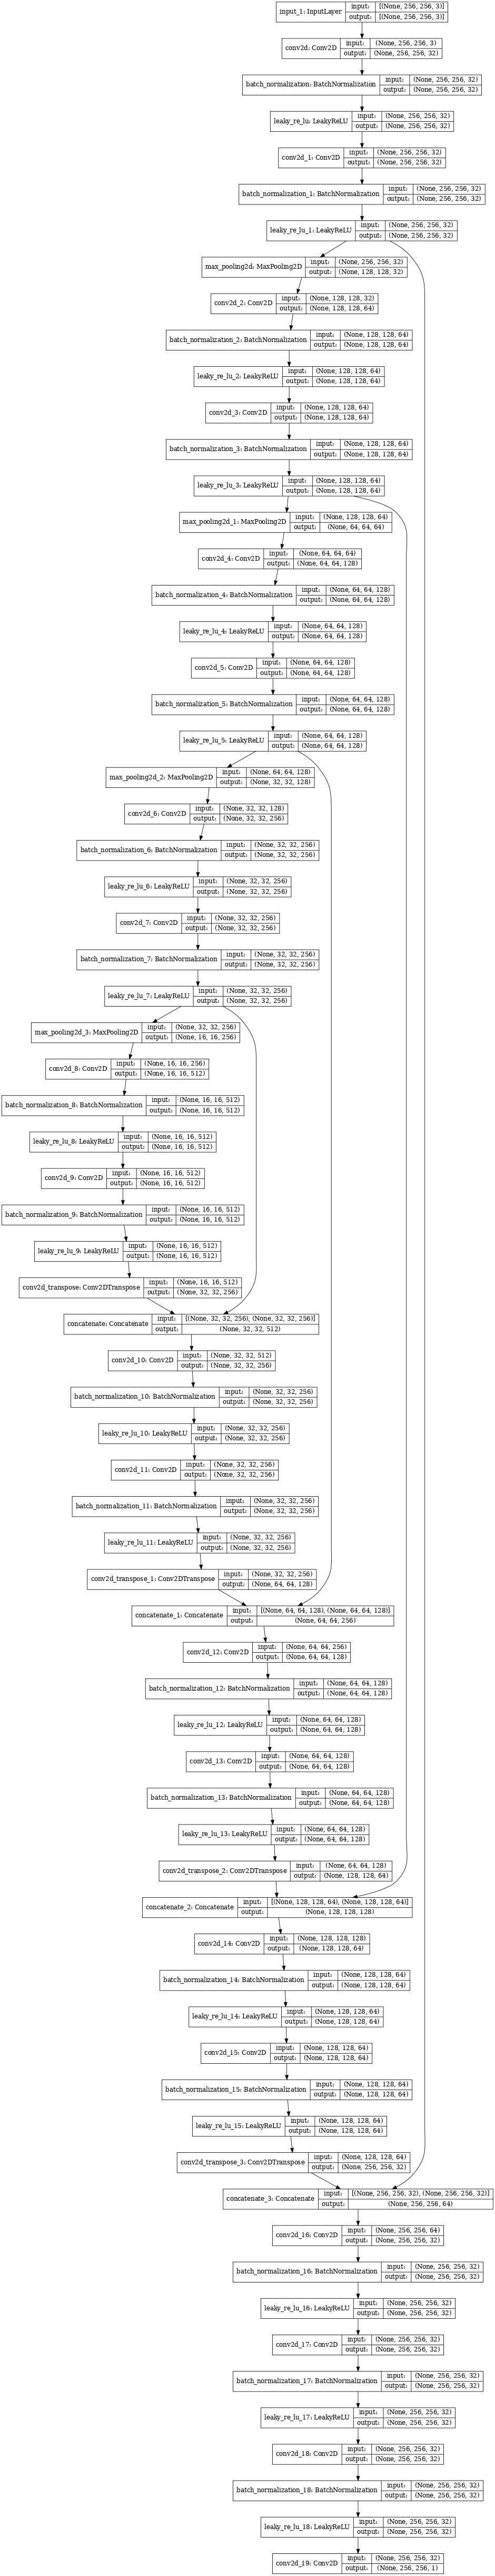

In [14]:
model = unet_from_scratch()

# plotovanje naseg modela
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=60
)

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss=[jaccard_loss],metrics=[jaccard_coef])

In [16]:
history = model.fit(x_train,y_train,batch_size=32,epochs=20,validation_split=0.2)

2021-12-12 14:19:03.011949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-12 14:19:06.536609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


30/30 [==============================] - 27s 505ms/step - loss: -0.1586 - jaccard_coef: 0.1594 - val_loss: -0.0414 - val_jaccard_coef: 0.0414
Epoch 2/20
30/30 [==============================] - 12s 399ms/step - loss: -0.2775 - jaccard_coef: 0.2782 - val_loss: -0.0444 - val_jaccard_coef: 0.0444
Epoch 3/20
30/30 [==============================] - 12s 402ms/step - loss: -0.4052 - jaccard_coef: 0.4061 - val_loss: -0.0526 - val_jaccard_coef: 0.0525
Epoch 4/20
30/30 [==============================] - 12s 414ms/step - loss: -0.5536 - jaccard_coef: 0.5553 - val_loss: -0.0649 - val_jaccard_coef: 0.0647
Epoch 5/20
30/30 [==============================] - 12s 398ms/step - loss: -0.6859 - jaccard_coef: 0.6866 - val_loss: -0.1328 - val_jaccard_coef: 0.1327
Epoch 6/20
30/30 [==============================] - 12s 415ms/step - loss: -0.7723 - jaccard_coef: 0.7728 - val_loss: -0.3705 - val_jaccard_coef: 0.3709
Epoch 7/20
30/30 [==============================] - 12s 399ms/step - loss: -0.8187 - jaccard_

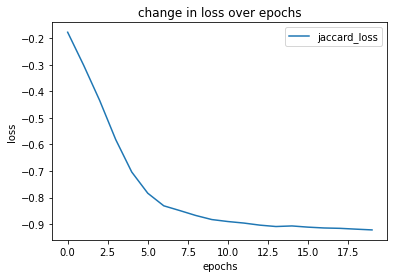

In [12]:
# Plotovanje promene funkcije gubitka u periodu od 20 epoha
x = [i for i in range(20)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['jaccard_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [18]:
predictions = model.predict(x_test)

# Pomoćne funkcije

In [69]:
def create_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.6] = 1
    return mask

def create_inverted_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions<0.6] = 1
    return mask

In [59]:
def plot_results_for_one_sample(predictions,sample_index):
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(y_test[sample_index])
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(mask)
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(x_test[sample_index]*mask)

In [30]:
def plot_background_change(predictions,sample_index,background_index):
    mask_inverted = create_inverted_mask(predictions[sample_index])
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,3,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,3,2)
    plt.title('Input backgound')
    plt.imshow(backs_arr[background_index])
    f.add_subplot(1,3,3)
    plt.title('Swaped background')
    plt.imshow((backs_arr[background_index]*mask_inverted) + x_test[sample_index]*mask)

# Plotovanje rezultata treniranja

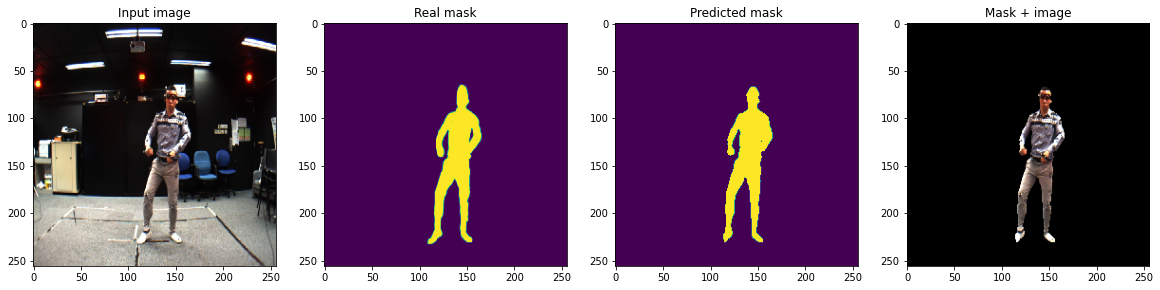

In [66]:
plot_results_for_one_sample(predictions,0)

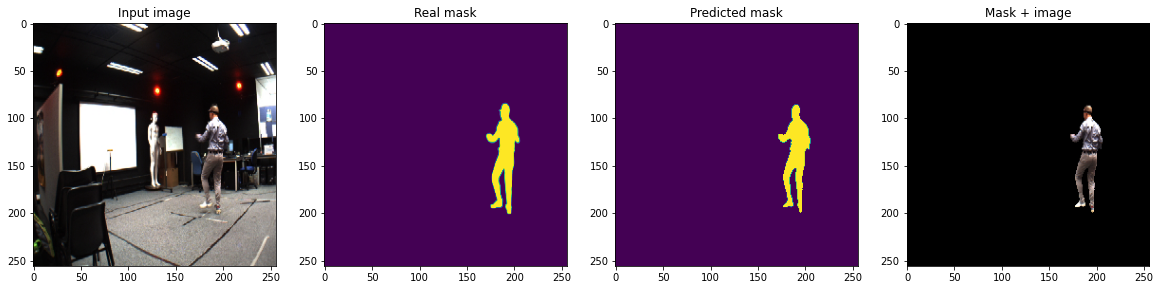

In [67]:
plot_results_for_one_sample(predictions,1)

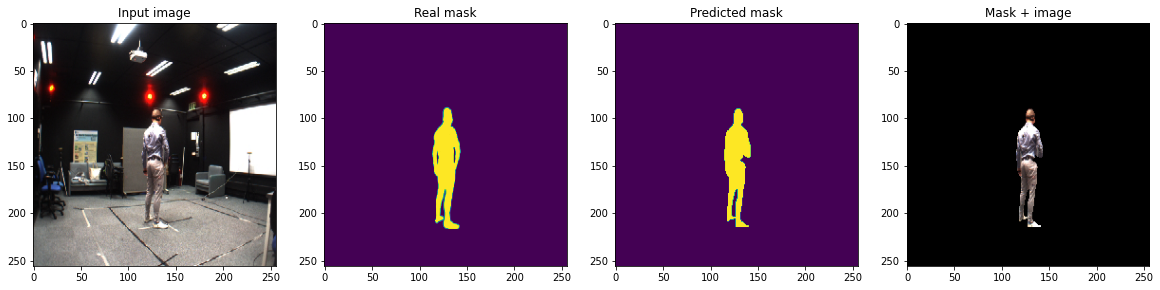

In [68]:
plot_results_for_one_sample(predictions,2)

# Prikazivanje jednog slučaja korišćenja ovog modela: Promena pozadina

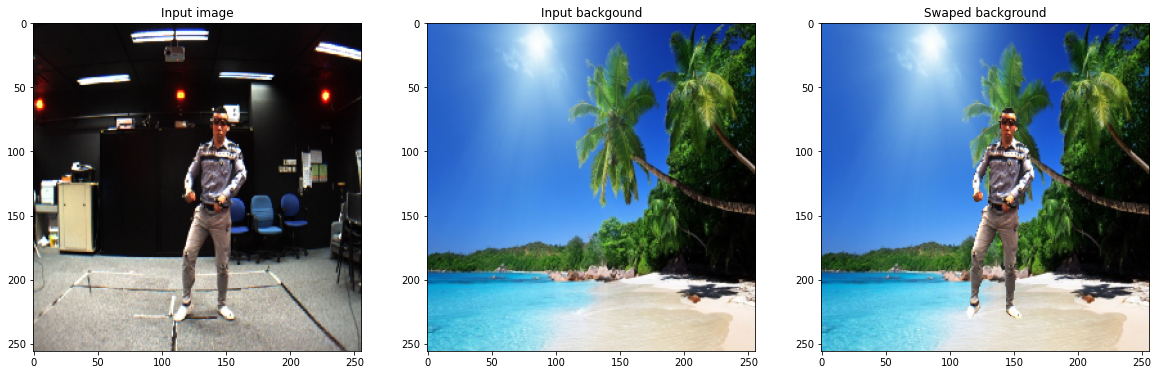

In [34]:
plot_background_change(predictions,0,0)

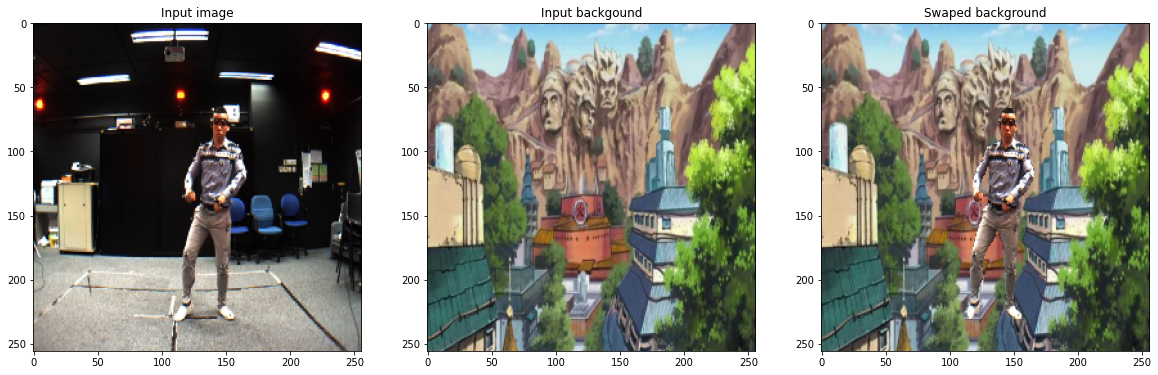

In [35]:
plot_background_change(predictions,0,1)

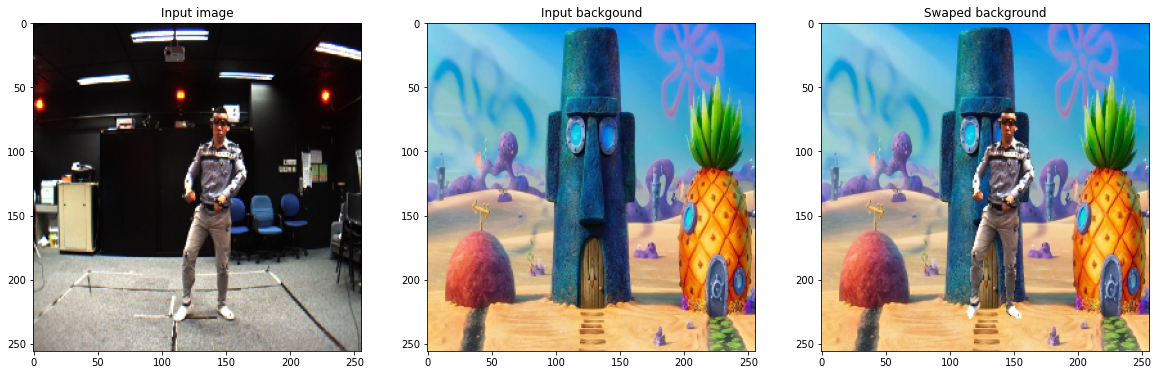

In [36]:
plot_background_change(predictions,0,2)

In [37]:
!pip install -q git+https://github.com/tensorflow/examples.git

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


# UNET model napravljen koristeći već istrenirane arhitekture. Koristićemo VGG16 za koder i PIX2PIX upsamle slojeve za dekoder

In [38]:
def unet_pretrained(input_shape=(256,256,3),number_of_classes = 1):
    # učitavanje vgg16 modela
    encoder = tf.keras.applications.vgg16.VGG16(
        include_top=False,weights='imagenet',
        input_shape=(256,256,3)
    )
    # zaleđivanje slojeva
    for layer in encoder.layers:
        layer.trainable = False

    # učitavanje pix2pix upsample slojeva   
    from tensorflow_examples.models.pix2pix import pix2pix
    decoder = [
        pix2pix.upsample(512, 3),  
        pix2pix.upsample(256, 3),  
        pix2pix.upsample(128, 3),  
        pix2pix.upsample(64, 3),   
    ]
    skip1 = encoder.layers[2].output
    skip2 = encoder.layers[5].output
    skip3 = encoder.layers[9].output
    skip4 = encoder.layers[13].output
    
    x = encoder.layers[17].output
    x = decoder[0](x)
    x = concatenate([x,skip4],axis=3)
    x = decoder[1](x)
    x = concatenate([x,skip3],axis=3)
    x = decoder[2](x)
    x = concatenate([x,skip2],axis=3)
    x = decoder[3](x)
    x = concatenate([x,skip1],axis=3)
    
    x = Conv2D(32,3,padding='same',kernel_initializer='he_normal',activation='relu')(x)
    output = Conv2D(number_of_classes,1,padding='same',activation='sigmoid')(x)
    model = Model(inputs=encoder.input,outputs=output)
    return model

In [39]:
model1 = unet_pretrained()

58900480/58889256 [==============================] - 0s 0us/step


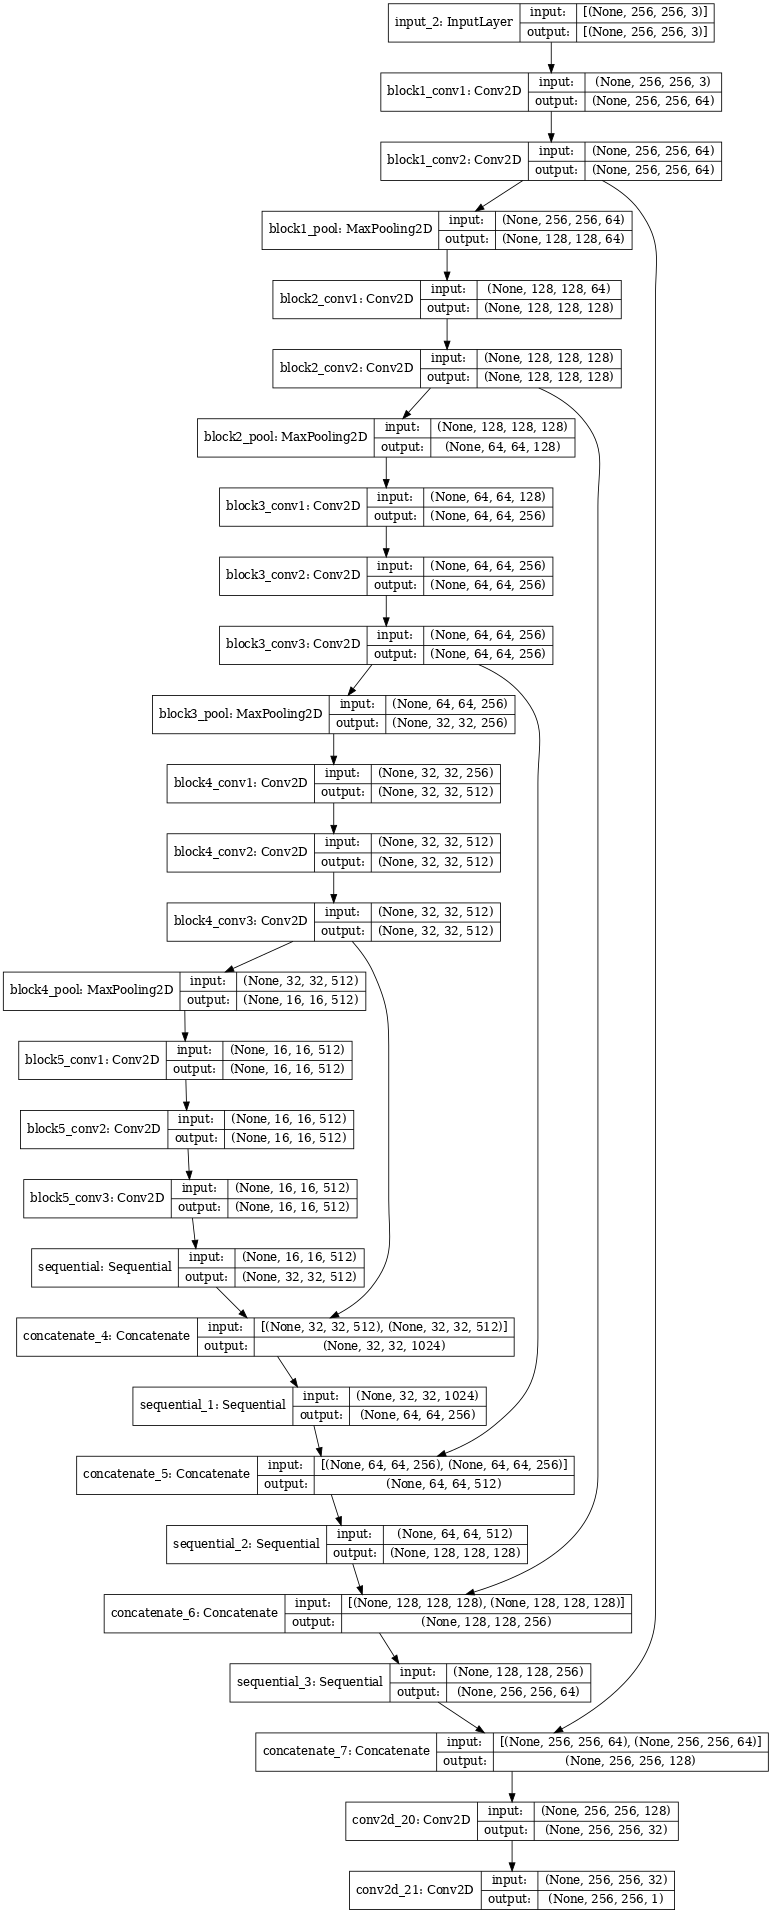

In [40]:
keras.utils.plot_model(
    model1,
    to_file="model1.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=60
)

In [52]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [41]:
model1.compile(optimizer=keras.optimizers.Adam(1e-3),loss = [jaccard_loss],metrics=[jaccard_coef])

In [42]:
history1 = model1.fit(x_train,y_train,batch_size=32,validation_split=0.2,epochs=20)

Epoch 1/20
30/30 [==============================] - 27s 689ms/step - loss: -0.5056 - jaccard_coef: 0.5101 - val_loss: -0.1734 - val_jaccard_coef: 0.1735
Epoch 2/20
30/30 [==============================] - 15s 518ms/step - loss: -0.8103 - jaccard_coef: 0.8109 - val_loss: -0.4542 - val_jaccard_coef: 0.4527
Epoch 3/20
30/30 [==============================] - 15s 517ms/step - loss: -0.8519 - jaccard_coef: 0.8521 - val_loss: -0.7920 - val_jaccard_coef: 0.7908
Epoch 4/20
30/30 [==============================] - 14s 479ms/step - loss: -0.8739 - jaccard_coef: 0.8739 - val_loss: -0.8615 - val_jaccard_coef: 0.8606
Epoch 5/20
30/30 [==============================] - 15s 516ms/step - loss: -0.8875 - jaccard_coef: 0.8877 - val_loss: -0.8818 - val_jaccard_coef: 0.8814
Epoch 6/20
30/30 [==============================] - 14s 479ms/step - loss: -0.8966 - jaccard_coef: 0.8967 - val_loss: -0.8883 - val_jaccard_coef: 0.8878
Epoch 7/20
30/30 [==============================] - 15s 516ms/step - loss: -0.9050

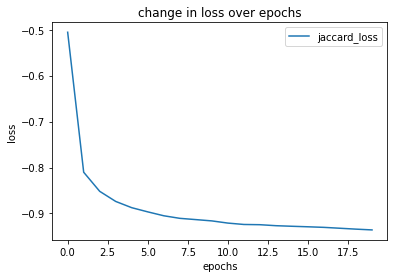

In [51]:
# Plotovanje promene funkcije gubitka u periodu od 20 epoha
x = [i for i in range(20)]
plt.plot(x,history1.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['jaccard_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [50]:
predictions1 = model1.predict(x_test)

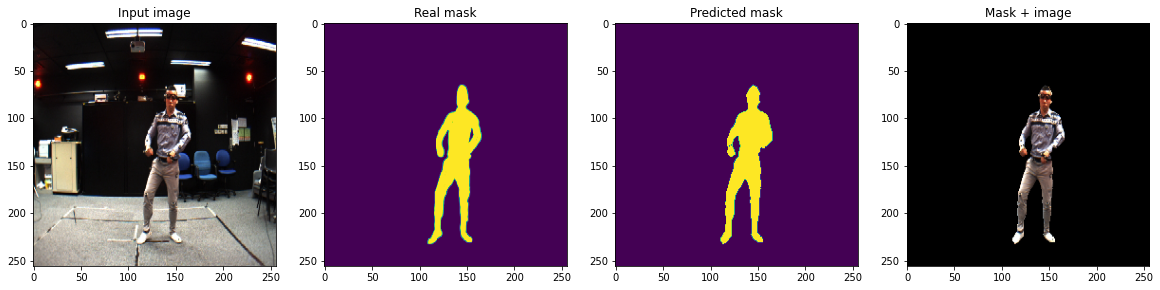

In [44]:
plot_results_for_one_sample(predictions1,0)

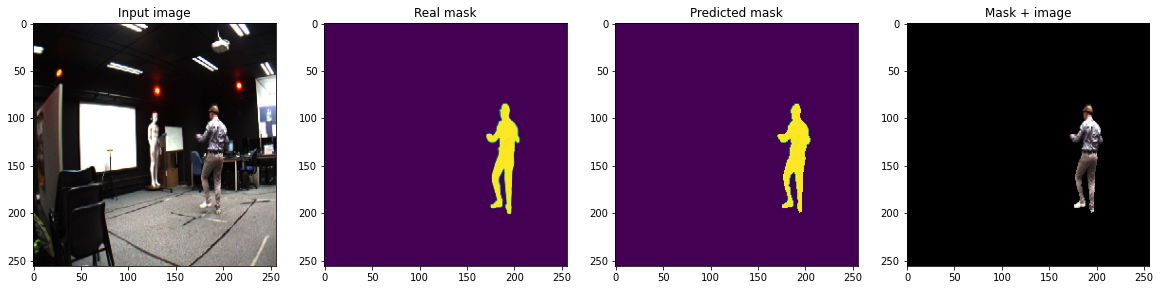

In [45]:
plot_results_for_one_sample(predictions1,1)

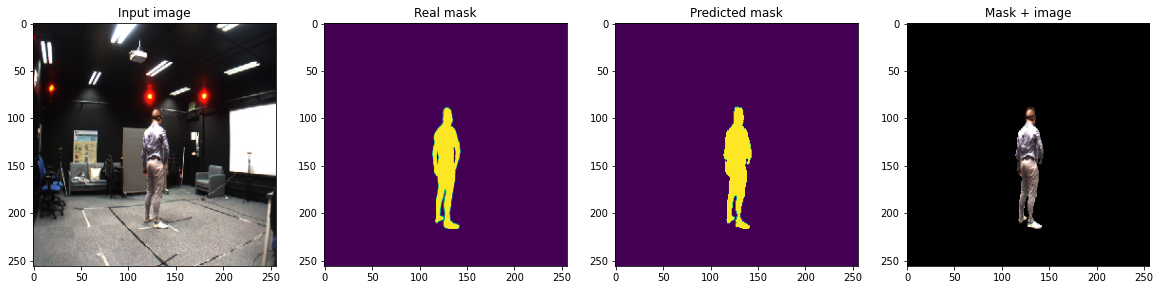

In [46]:
plot_results_for_one_sample(predictions1,2)

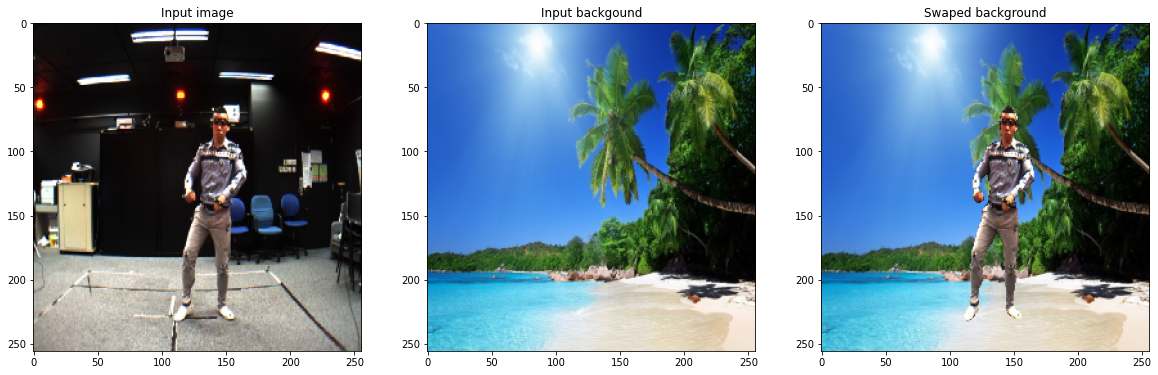

In [47]:
plot_background_change(predictions1,0,0)

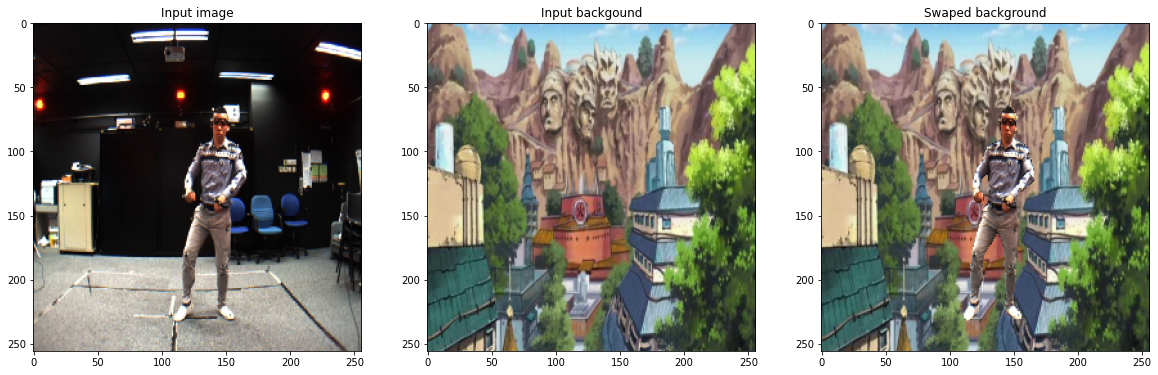

In [48]:
plot_background_change(predictions1,0,1)

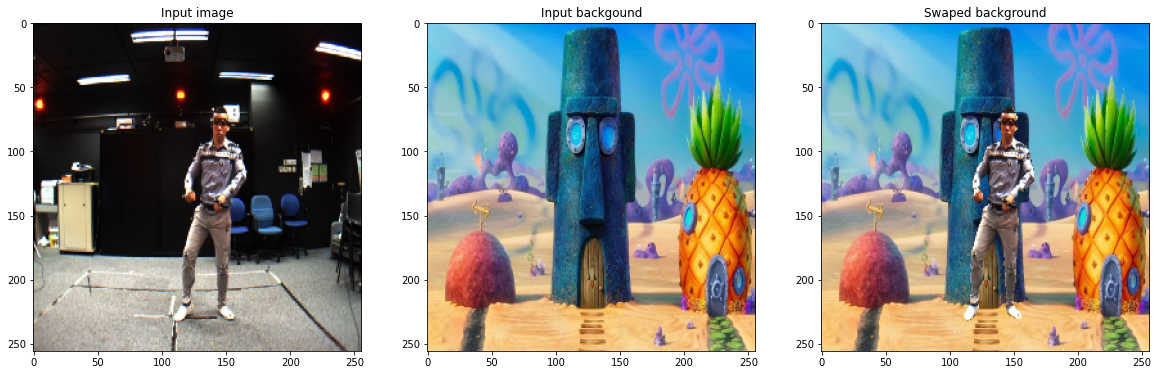

In [49]:
plot_background_change(predictions1,0,2)

# Rezultati

Možemo primetiti da oba modela imaju jako slične performanse (razlika od ~= 0.01 za funkciju gubitka na kraju perioda od 20 epoha),<br> ali kada koristimo vec istrenirane mreže brže konvergiramo u lokalni minimum (vec od 11-te epohe imamo jaccard loss od 0.90).<br>
Druga razlika je u tome da iako je preistrenirana mreža veća od mreže koju smo napravili od nule (20m parametara u odnosu na 8m), pošto smo zaledili slojeve u koderu (u fazi treniranja nećemo učiti parametre kodera), ona ima manje parametara koji se uče nego mreža koju smo napravili od nule(5m parametara u odnosu na 8m), stoga će vreme za izvršavanje jedne epohe biti kraće.